#CNN (convolutional neural network)

In [7]:
import zipfile

with zipfile.ZipFile('/content/flowers.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/flowers')


In [8]:
import os

# Шлях до папки train
train_dir = '/content/flowers/train'

print("Train dataset:")
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Перевіряємо, чи це папка
        print(f"Class: {class_name}, Number of images: {len(os.listdir(class_path))}")

# Шлях до папки test
test_dir = '/content/flowers/test'

print("\nTest dataset:")
print(f"Number of test images: {len(os.listdir(test_dir))}")

Train dataset:
Class: tulip, Number of images: 607
Class: rose, Number of images: 497
Class: dandelion, Number of images: 646
Class: daisy, Number of images: 501
Class: sunflower, Number of images: 495

Test dataset:
Number of test images: 924


In [9]:
!pip install split-folders

import splitfolders

splitfolders.ratio('/content/flowers/train', output="/content/flowers_split", seed=42, ratio=(.8, .2))

Copying files: 2746 files [00:01, 2489.70 files/s]


In [10]:
import os

print("Train classes:", os.listdir('/content/flowers_split/train'))
print("Val classes:", os.listdir('/content/flowers_split/val'))

Train classes: ['tulip', 'rose', 'dandelion', 'daisy', 'sunflower']
Val classes: ['tulip', 'rose', 'dandelion', 'daisy', 'sunflower']


# Сhecking

In [8]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

test_dir = '/content/flowers/test'
image_size = (240, 240)

# Завантаження тестових зображень
test_images = []
for file in os.listdir(test_dir):
    if file.endswith(('.jpg', '.png')):  # Враховуємо лише зображення
        img = load_img(os.path.join(test_dir, file), target_size=image_size)
        test_images.append(img_to_array(img))

test_images = np.array(test_images) / 255.0  # Нормалізація
print(f"Завантажено {len(test_images)} тестових зображень.")

Завантажено 924 тестових зображень.


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

train_dir = '/content/flowers_split/train'
val_dir = '/content/flowers_split/val'

# Створюємо DataFrame з шляхами до зображень
test_df = pd.DataFrame({
    'filename': os.listdir(test_dir),
    'class': ['unknown'] * len(os.listdir(test_dir))  # Або додайте реальні мітки, якщо є
})

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Розмір зображень
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,  # Якщо мітки відсутні
    target_size=(240, 240),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 2194 images belonging to 5 classes.
Found 552 images belonging to 5 classes.
Found 924 validated image filenames.


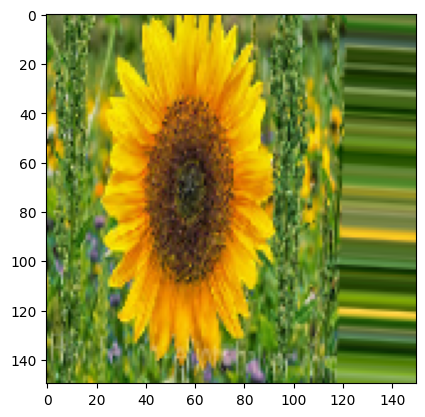

In [10]:
import matplotlib.pyplot as plt
import numpy as np

x, y = next(train_generator)  # Отримати одну партію
plt.imshow(x[0])  # Показати перше зображення
plt.show()

In [11]:
# Перевірка кількості зображень
print(f"Кількість тренувальних зображень: {train_generator.samples}")
print(f"Кількість валідаційних зображень: {val_generator.samples}")
print(f"Кількість тестових зображень: {test_generator.samples}")

Кількість тренувальних зображень: 2194
Кількість валідаційних зображень: 552
Кількість тестових зображень: 924


# Create model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu',strides=1, padding='valid'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu',strides=1, padding='valid'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu',strides=1, padding='valid'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # L2-регуляризація
    Dropout(0.5),  # Запобігання перенавчанню

    Dense(5, activation='softmax')  # 5 класів
])


In [13]:
# Компіляція моделі
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
# Огляд моделі
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,367,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,424,581 (9.25 MB)

 Trainable params: 2,424,581 (9.25 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
# Рання зупинка
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Зупинити навчання після 3 епох без покращення
    restore_best_weights=True
)

In [1]:
!pip install --upgrade tensorflow keras

In [16]:
# Навчання моделі
scratch_history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.2758 - loss: 2.7482 - val_accuracy: 0.4312 - val_loss: 1.4262
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.4193 - loss: 1.5280 - val_accuracy: 0.4837 - val_loss: 1.3642
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.4809 - loss: 1.3559 - val_accuracy: 0.5181 - val_loss: 1.2326
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.5368 - loss: 1.2759 - val_accuracy: 0.5145 - val_loss: 1.2635
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.5588 - loss: 1.2192 - val_accuracy: 0.5688 - val_loss: 1.2167
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.6017 - loss: 1.1745 - val_accuracy: 0.5634 - val_loss: 1.1296
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.5931 - loss: 1.1528 - val_accuracy: 0.5743 - val_loss: 1.1253
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.5926 - loss: 1.1280 - val_accuracy: 0.6214 - v

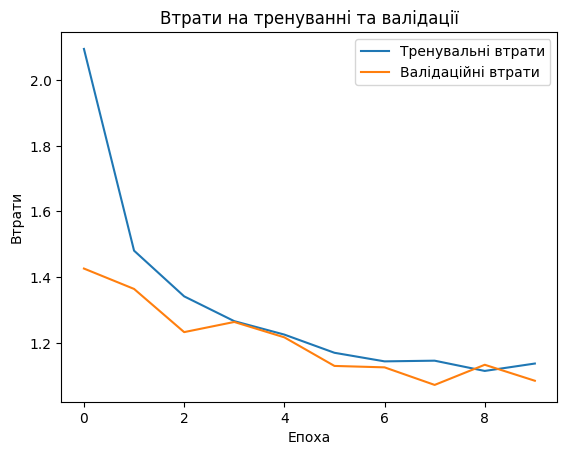

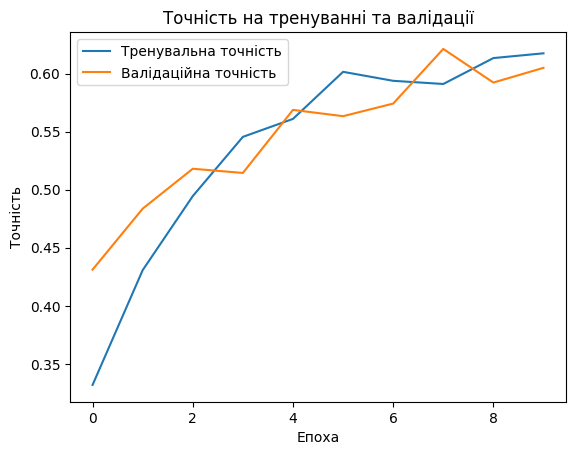

In [17]:
import matplotlib.pyplot as plt

# Витягуємо історію навчання
history = scratch_history.history

# Графік втрат
plt.plot(history['loss'], label='Тренувальні втрати')
plt.plot(history['val_loss'], label='Валідаційні втрати')
plt.title('Втрати на тренуванні та валідації')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()
plt.show()

# Графік точності
plt.plot(history['accuracy'], label='Тренувальна точність')
plt.plot(history['val_accuracy'], label='Валідаційна точність')
plt.title('Точність на тренуванні та валідації')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.show()

In [18]:
import pandas as pd
import os

# Створюємо DataFrame з файлами в тестовій папці
test_dir = '/content/flowers/test'  # Шлях до папки з тестовими зображеннями
test_filenames = os.listdir(test_dir)  # Отримуємо список файлів

# Створюємо DataFrame
test_df = pd.DataFrame({
    'filename': test_filenames
})

print(test_df.head())  # Перевіряємо DataFrame

        filename
0  Image_527.jpg
1  Image_319.jpg
2  Image_514.jpg
3  Image_553.jpg
4  Image_774.jpg


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)  # Нормалізація зображень

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,  # Мітки відсутні
    target_size=(150, 150),  # Розмір зображень, як під час тренування
    batch_size=32,
    class_mode=None,  # Генератор без міток
    shuffle=False
)

Found 924 validated image filenames.


In [20]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Отримуємо передбачені класи
print(predicted_classes)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 538ms/step
[4 3 4 1 4 4 0 4 0 4 4 1 4 1 3 1 3 0 4 4 3 4 4 4 2 1 4 1 3 3 0 0 3 3 4 0 3
 3 0 3 1 4 3 4 1 4 1 3 3 1 1 3 1 2 3 3 3 4 1 1 4 0 3 0 1 3 1 4 4 1 4 1 1 0
 1 0 1 4 2 3 1 4 3 3 4 1 0 4 1 1 4 4 1 4 3 1 4 0 4 2 0 1 1 0 0 1 1 4 3 4 0
 0 3 4 4 4 4 4 3 3 0 0 4 4 0 1 3 3 4 0 4 4 3 3 4 1 3 1 2 4 4 1 3 4 4 1 1 1
 1 3 1 1 3 1 3 1 1 4 4 4 3 2 3 2 1 0 4 4 2 4 4 1 1 3 4 3 3 3 4 1 4 3 1 1 1
 0 1 0 4 1 1 4 0 1 3 1 1 4 4 3 3 2 1 2 1 1 4 3 0 0 2 4 3 1 0 1 4 1 0 4 1 1
 4 4 3 3 4 1 0 1 4 2 3 1 0 1 4 1 3 1 4 2 1 3 4 2 1 4 4 4 0 1 4 4 4 4 2 1 3
 1 3 0 4 3 1 0 4 1 1 4 0 1 0 2 0 3 3 3 1 4 3 4 4 1 4 0 3 4 3 4 4 3 1 0 3 4
 1 3 4 4 1 3 1 4 4 1 4 1 4 1 3 4 1 3 1 4 2 2 4 1 4 3 3 1 1 0 4 4 1 1 1 4 3
 3 3 0 4 1 1 4 3 3 4 0 4 0 3 4 3 1 3 0 4 2 1 2 3 4 4 0 3 2 1 3 3 1 4 1 4 1
 3 4 4 0 3 4 1 3 3 4 1 3 1 1 3 4 4 0 1 2 3 1 4 3 1 3 4 1 4 1 0 4 4 3 4 3 4
 1 4 0 4 3 4 4 4 4 4 4 4 0 3 0 4 3 0 1 4 2 3 1 1 4 1 0 3 1 2 1 4 0 4 3 1 1
 3 1 0 0 3 4 3 1 2 4 4 1 1 4 1 0 2 3 3 3 4 1 1 4 4 3 0 1 4

In [24]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Отримуємо відповідність між назвами папок і мітками
class_indices = train_generator.class_indices
print(class_indices)

Found 2194 images belonging to 5 classes.
{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [25]:
import pandas as pd
# Інвертуємо class_indices для зручного доступу
label_map = {v: k for k, v in class_indices.items()}

# Додаємо передбачені класи до DataFrame
test_df['predicted_class'] = predicted_classes

# Зберігаємо результати в CSV
test_df.to_csv('test_predictions.csv', index=False)
print("Передбачення збережено в test_predictions.csv")


Передбачення збережено в test_predictions.csv


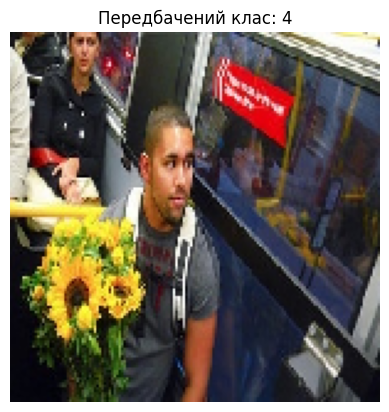

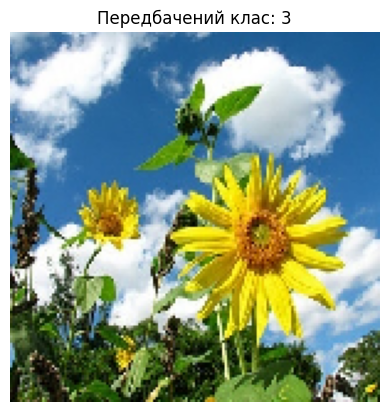

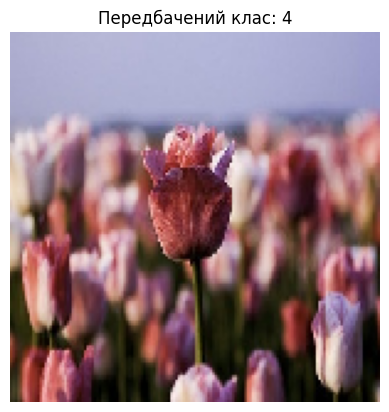

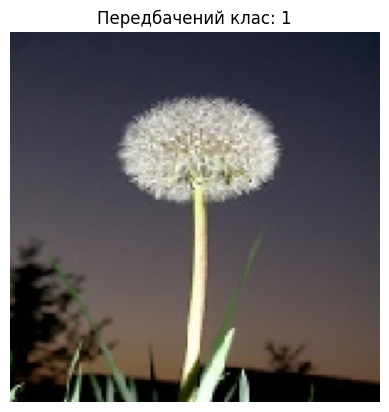

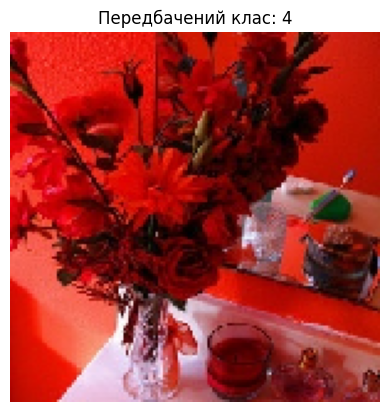

In [26]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img

# Виводимо кілька зображень із передбаченими класами
for i in range(5):  # Змінюйте кількість за потребою
    img_path = os.path.join(test_dir, test_df['filename'].iloc[i])
    img = load_img(img_path, target_size=(150, 150))  # Розмір зображення має відповідати розміру під час тренування

    plt.imshow(img)
    plt.title(f"Передбачений клас: {test_df['predicted_class'].iloc[i]}")
    plt.axis('off')
    plt.show()


#Transfer learning

In [27]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [28]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


<ipython-input-28-3e07fd31b914>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
base_model.trainable = False


In [30]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Глобальний середній пулінг
    Dense(128, activation='relu'),  # Повнозв'язний шар
    Dropout(0.5),  # Dropout для запобігання перенавчанню
    Dense(5, activation='softmax')  # Вихідний шар для 5 класів
])

In [32]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4770 - loss: 1.4189 - val_accuracy: 0.7736 - val_loss: 0.5776
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7204 - loss: 0.7056 - val_accuracy: 0.8116 - val_loss: 0.5130
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7753 - loss: 0.6187 - val_accuracy: 0.8116 - val_loss: 0.5282
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8245 - loss: 0.5192 - val_accuracy: 0.8424 - val_loss: 0.4676
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8141 - loss: 0.4809 - val_accuracy: 0.8297 - val_loss: 0.4497
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8156 - loss: 0.4859 - val_accuracy: 0.8388 - val_loss: 0.4474
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8427 - loss: 0.4466 - val_accuracy: 0.8315 - val_loss: 0.4652
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8394 - loss: 0.4194 - val_accuracy: 0.8333 - val_loss:

In [35]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 747ms/step
[3 3 4 1 2 2 0 4 0 4 3 1 0 1 3 2 3 0 2 4 3 4 4 0 2 0 4 1 3 3 2 0 3 3 4 3 3
 3 4 3 1 4 2 2 1 1 4 3 3 1 1 3 1 4 3 3 3 2 1 1 4 1 3 0 1 3 3 4 2 2 2 4 1 3
 2 0 1 2 1 3 1 2 3 3 4 1 0 4 4 0 4 2 0 4 3 3 4 1 2 2 4 2 0 0 0 1 1 0 3 2 0
 0 0 4 2 3 3 4 3 3 0 0 1 4 0 1 3 3 4 4 4 4 3 3 2 3 3 1 1 4 4 4 3 3 3 1 1 1
 3 3 0 2 3 0 3 1 1 4 4 4 3 1 3 1 1 0 4 4 0 4 2 1 1 3 4 3 3 3 4 1 3 3 1 1 1
 3 1 3 1 2 1 2 0 1 3 1 3 4 4 3 1 2 1 3 0 1 4 1 0 1 2 4 3 0 0 4 4 1 3 4 1 3
 2 4 3 3 4 1 0 1 4 2 4 1 2 1 2 1 3 1 2 2 1 3 4 2 2 4 4 4 4 0 2 0 4 3 2 1 3
 2 0 0 4 4 1 0 3 4 3 4 2 1 0 1 0 3 3 3 1 2 3 2 4 1 2 3 3 4 3 2 4 3 3 0 3 4
 3 3 4 4 1 3 2 2 2 1 4 1 4 3 3 1 1 3 1 2 1 2 4 1 4 3 3 1 1 4 4 4 1 0 2 4 3
 3 3 0 2 1 2 4 3 3 2 0 4 0 2 4 1 1 3 0 4 4 0 4 3 2 2 0 3 2 1 1 3 1 4 1 4 1
 3 4 2 0 1 4 3 1 3 4 1 4 1 2 3 2 2 0 4 2 3 3 2 3 4 3 2 1 2 1 0 4 4 3 4 3 0
 1 3 2 2 3 0 4 4 3 4 3 4 2 3 0 4 3 0 1 4 2 3 1 4 2 3 1 3 1 4 2 4 0 2 3 0 1
 3 3 1 0 1 4 3 1 2 4 4 2 4 3 1 0 2 3 3 3 2 0 2 2 2 3 2 2 4

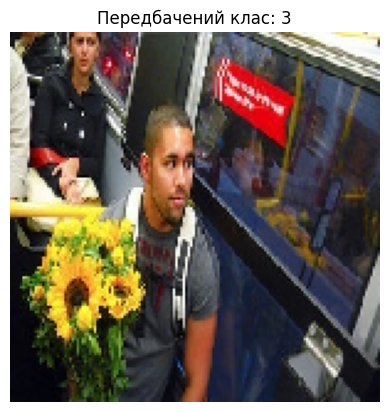

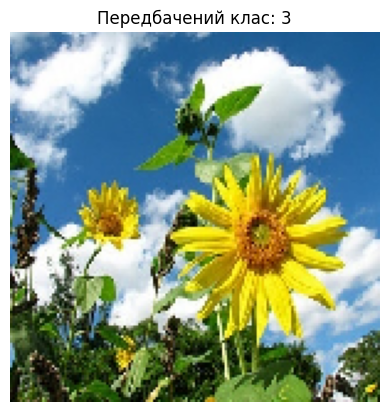

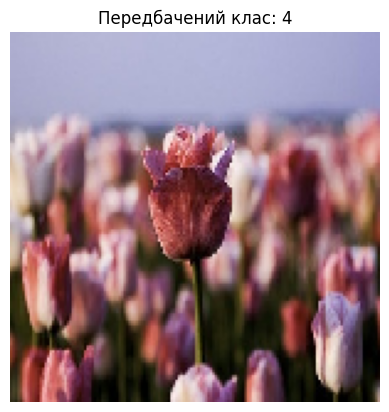

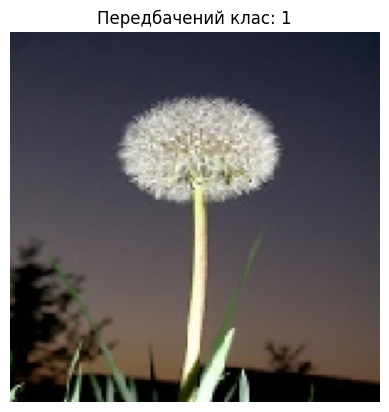

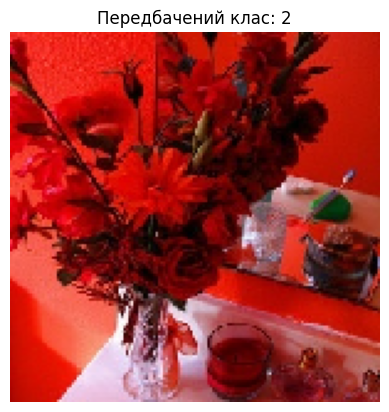

In [37]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import os

for i in range(5):  # Перегляд кількох зображень
    img_path = os.path.join(test_dir, test_df['filename'].iloc[i])
    img = load_img(img_path, target_size=(150, 150))
    plt.imshow(img)
    plt.title(f"Передбачений клас: {predicted_classes[i]}")
    plt.axis('off')
    plt.show()